In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Artificial Neural Network

In [2]:
df = pd.read_csv('data4.csv', encoding='ISO-8859-1')
df.head()

,Name,Present,Previous,CU.M.,Amount,Area_Number,Date,Initial
0,"Abainza, Jouie",1056,1051,5,130,1,2020-Jan,130
1,"Adam, Eduardo",NaN,NaN,NaN,NaN,1,2020-Jan,130
2,"Adam, Evelyn II",2178,2164,52,834,1,2020-Jan,130
3,"Agosto, Juanario",4167,4140,27,434,1,2020-Jan,130
4,"Albano, Gina",NaN,NaN,NaN,NaN,1,2020-Jan,130


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65011 entries, 0 to 65010
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         65009 non-null  object
 1   Present      59739 non-null  object
 2   Previous     59866 non-null  object
 3   CU.M.        60003 non-null  object
 4   Amount       59948 non-null  object
 5   Area_Number  65011 non-null  int64 
 6   Date         65011 non-null  object
 7   Initial      65011 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.0+ MB


# Data Cleaning (Pre-Processing)

In [4]:
# Check for missing values
print(df.isnull().sum())

Name              2
Present        5272
Previous       5145
CU.M.          5008
Amount         5063
Area_Number       0
Date              0
Initial           0
dtype: int64


In [5]:
df['Present'] = pd.to_numeric(df['Present'], errors='coerce').fillna(0).astype(int)
df['Previous'] = pd.to_numeric(df['Previous'], errors='coerce').fillna(0).astype(int)
df['CU.M.'] = pd.to_numeric(df['CU.M.'], errors='coerce').fillna(0).astype(int)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0).astype(int)

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%b')

df.set_index('Date', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65011 entries, 2020-01-01 to 2024-05-01
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         65009 non-null  object
 1   Present      65011 non-null  int32 
 2   Previous     65011 non-null  int32 
 3   CU.M.        65011 non-null  int32 
 4   Amount       65011 non-null  int32 
 5   Area_Number  65011 non-null  int64 
 6   Initial      65011 non-null  int64 
dtypes: int32(4), int64(2), object(1)
memory usage: 3.0+ MB


# Feature Engineering

In [7]:
# Reset the index to bring Date back as a column
df_reset = df.reset_index()

# Group by the Date and sum both Amount and CU.M. columns
monthly_sum = df_reset.groupby(df_reset['Date'].dt.to_period('M'))[['Amount', 'CU.M.']].sum().reset_index()

# Round the Amount and CU.M. columns to 2 decimal places
monthly_sum['Amount'] = monthly_sum['Amount'].round(2)
monthly_sum['CU.M.'] = monthly_sum['CU.M.'].round(2)

# Display the result
print(monthly_sum)


       Date  Amount  CU.M.
0   2020-01  391814  24106
1   2020-02  384230  23574
2   2020-03  446286  26434
3   2020-04  424098  25970
4   2020-05  447320  30497
5   2020-06  444322  27419
6   2020-07  428278  26376
7   2020-08  414622  25478
8   2020-09  413302  25371
9   2020-10  410570  25183
10  2020-11  393536  24076
11  2020-12  383500  23464
12  2021-01  397710  24329
13  2021-02  464870  23212
14  2021-03  527832  26836
15  2021-04  513570  26061
16  2021-05  572876  29439
17  2021-06  496962  25059
18  2021-07  494514  24994
19  2021-08  511808  26000
20  2021-09  479242  24098
21  2021-10  495200  24973
22  2021-11  481448  24245
23  2021-12  491672  24779
24  2022-01  487490  24546
25  2022-02  491780  24236
26  2022-03  507728  25734
27  2022-04  497378  25179
28  2022-05  524186  26777
29  2022-06  504590  25645
30  2022-07  516710  26301
31  2022-08  520412  26505
32  2022-09  501054  25377
33  2022-10  514356  26073
34  2022-11  522000  24739
35  2022-12  524620  24784
3

# Getting the feature (Cubic Meter) and Target (Amount)

In [8]:
# Select the features (CU.M.) and target (Amount)
features = monthly_sum[['CU.M.']]
target = monthly_sum['Amount']

# Normalize the features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Function to create sequences of data for time series prediction
def create_sequences(X, y, sequence_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Define the sequence length (e.g., 12 months for a year)
sequence_length = 12

# Call the function and pass the sequence length
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Reshape input to [samples, time steps, features]
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# Building the ANN Model

In [9]:
# Build the ANN model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_seq, y_seq, epochs=50, batch_size=32)



Epoch 1/50

2/2 [==============================] - 4s 16ms/step - loss: 0.3025
Epoch 2/50
2/2 [==============================] - 0s 14ms/step - loss: 0.2403
Epoch 3/50
2/2 [==============================] - 0s 14ms/step - loss: 0.1774
Epoch 4/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1202
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0711
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0294
Epoch 7/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0254
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0447
Epoch 9/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0485
Epoch 10/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0239
Epoch 11/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0180
Epoch 12/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0197
Epoch 13/50
2/2 [==============================] - 0s 13ms

In [10]:
# Use the trained model to predict future amounts
predicted_amounts = model.predict(X_seq)

# Rescale the predicted amounts back to the original scale
predicted_amounts_rescaled = scaler_y.inverse_transform(predicted_amounts)

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(index=monthly_sum.index[sequence_length:], data={'Predicted_Amount': predicted_amounts_rescaled.flatten()})

# Add predictions to the original DataFrame
monthly_sum = monthly_sum.join(predictions_df, how='left')

2/2 [==============================] - 1s 5ms/step


# Visualizing the Predicted and Original Value

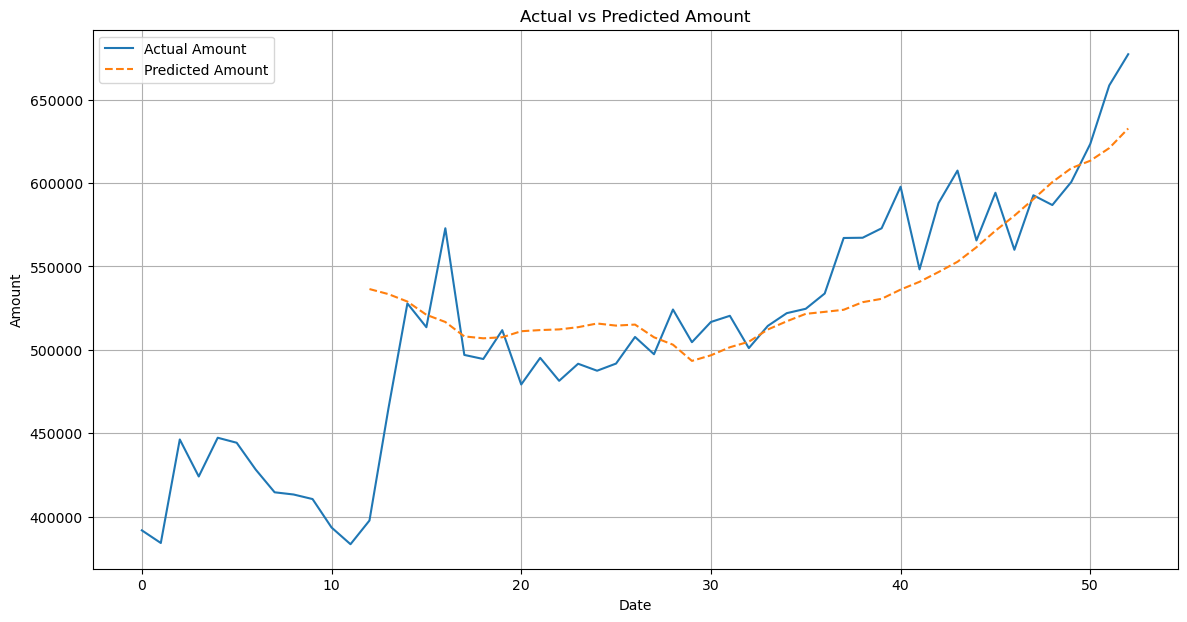

In [11]:
# Plot the actual and predicted amounts
plt.figure(figsize=(14, 7))
plt.plot(monthly_sum.index, monthly_sum['Amount'], label='Actual Amount')
plt.plot(monthly_sum.index, monthly_sum['Predicted_Amount'], label='Predicted Amount', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Actual vs Predicted Amount')
plt.legend()
plt.grid(True)
plt.show()


# Evaluating the Accuracy of the Model

In [12]:
# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(monthly_sum['Amount'].iloc[sequence_length:], monthly_sum['Predicted_Amount'].iloc[sequence_length:])
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sum['Amount'].iloc[sequence_length:], monthly_sum['Predicted_Amount'].iloc[sequence_length:])

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 1257178344.96
Root Mean Squared Error (RMSE): 35456.71
Mean Absolute Error (MAE): 24842.04


# Forecasting Amount up to Dec 2025

In [16]:
# Reset index and prepare your data
df_reset = df.reset_index()
monthly_sum = df_reset.groupby(df_reset['Date'].dt.to_period('M'))[['Amount', 'CU.M.']].sum().reset_index()
monthly_sum['Amount'] = monthly_sum['Amount'].round(2)
monthly_sum['CU.M.'] = monthly_sum['CU.M.'].round(2)
monthly_sum['Date'] = monthly_sum['Date'].dt.to_timestamp()
monthly_sum.set_index('Date', inplace=True)

# Forecast future values
last_date = monthly_sum.index.max()

# Ensure 'last_date' is a Timestamp object for date arithmetic
if isinstance(last_date, pd.Period):
    last_date = last_date.to_timestamp()

# Define the future date range
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), end='2025-12-31', freq='M')

# Create a DataFrame for future dates with a placeholder for 'CU.M.'
future_df = pd.DataFrame(index=future_dates, columns=['CU.M.'])

# Initialize the last known sequence
last_sequence = X_scaled[-sequence_length:]
forecasted_amounts = []

for _ in range(len(future_dates)):
    # Predict the next value
    next_prediction_scaled = model.predict(last_sequence.reshape(1, sequence_length, 1))
    next_prediction = scaler_y.inverse_transform(next_prediction_scaled)[0, 0]
    forecasted_amounts.append(next_prediction)
    
    # Update the sequence with the new prediction
    # Use the mean CU.M. as a placeholder; replace with actual forecasted CU.M. if available
    new_cu_m = monthly_sum['CU.M.'].mean()  
    new_cu_m_scaled = scaler_X.transform([[new_cu_m]])[0, 0]
    last_sequence = np.append(last_sequence[1:], [[new_cu_m_scaled]], axis=0)

# Add forecasted values to the future DataFrame
future_df['Amount'] = forecasted_amounts

# Set the index name for clarity
future_df.index.name = 'Date'

1/1 [==============================] - ETA: 0s

D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


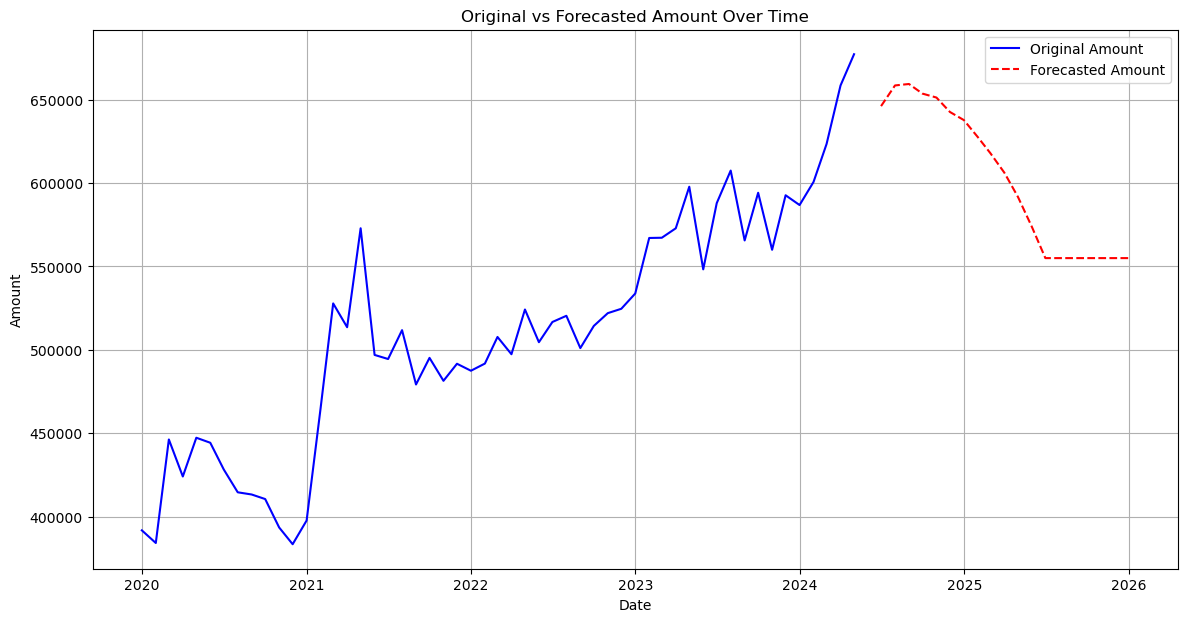

                 Amount
Date                   
2024-06-30  646091.9375
2024-07-31  658487.2500
2024-08-31  659352.9375
2024-09-30  653581.6250
2024-10-31  651238.3125
2024-11-30  642577.6250
2024-12-31  637716.4375
2025-01-31  627499.5625
2025-02-28  617820.3125
2025-03-31  606142.6875
2025-04-30  591713.5000
2025-05-31  573733.3125
2025-06-30  554994.3125
2025-07-31  554994.3125
2025-08-31  554994.3125
2025-09-30  554994.3125
2025-10-31  554994.3125
2025-11-30  554994.3125
2025-12-31  554994.3125


In [17]:
# Combine original data with forecasted data
combined_df = pd.concat([monthly_sum, future_df], axis=0)

# Plot actual and forecasted values
plt.figure(figsize=(14, 7))

# Plot original values
plt.plot(monthly_sum.index, monthly_sum['Amount'], label='Original Amount', color='blue')

# Plot forecasted values
plt.plot(future_df.index, future_df['Amount'], label='Forecasted Amount', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Original vs Forecasted Amount Over Time')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

# Print the forecasted values
print(future_df[['Amount']])

# Getting the Feature (Amount) and Target (Cu.M.)

In [18]:
# Select the features (CU.M.) and target (Amount)
features = monthly_sum[['Amount']]
target = monthly_sum['CU.M.']

# Normalize the features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Function to create sequences of data for time series prediction
def create_sequences(X, y, sequence_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Define the sequence length (e.g., 12 months for a year)
sequence_length = 12

# Call the function and pass the sequence length
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Reshape input to [samples, time steps, features]
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# Building the ANN model for Cubic Meter Forecasting

In [19]:
# Build the ANN model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_seq, y_seq, epochs=50, batch_size=32)

Epoch 1/50
2/2 [==============================] - 3s 12ms/step - loss: 0.1404
Epoch 2/50
2/2 [==============================] - 0s 16ms/step - loss: 0.0887
Epoch 3/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0461
Epoch 4/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0328
Epoch 5/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0394
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0384
Epoch 7/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0356
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0291
Epoch 9/50
2/2 [==============================] - 0s 19ms/step - loss: 0.0311
Epoch 10/50
2/2 [==============================] - 0s 14ms/step - loss: 0.0342
Epoch 11/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0315
Epoch 12/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0323
Epoch 13/50
2/2 [==============================] - 0s 13ms/st

In [21]:
# Use the trained model to predict future amounts
predicted_amounts = model.predict(X_seq)

# Rescale the predicted amounts back to the original scale
predicted_amounts_rescaled = scaler_y.inverse_transform(predicted_amounts)

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(index=monthly_sum.index[sequence_length:], data={'Predicted_CU.M.': predicted_amounts_rescaled.flatten()})

# Add predictions to the original DataFrame
monthly_sum = monthly_sum.join(predictions_df, how='left')

2/2 [==============================] - 1s 6ms/step


# Plotting the Forecasted Cubic Meter to Origianl Value

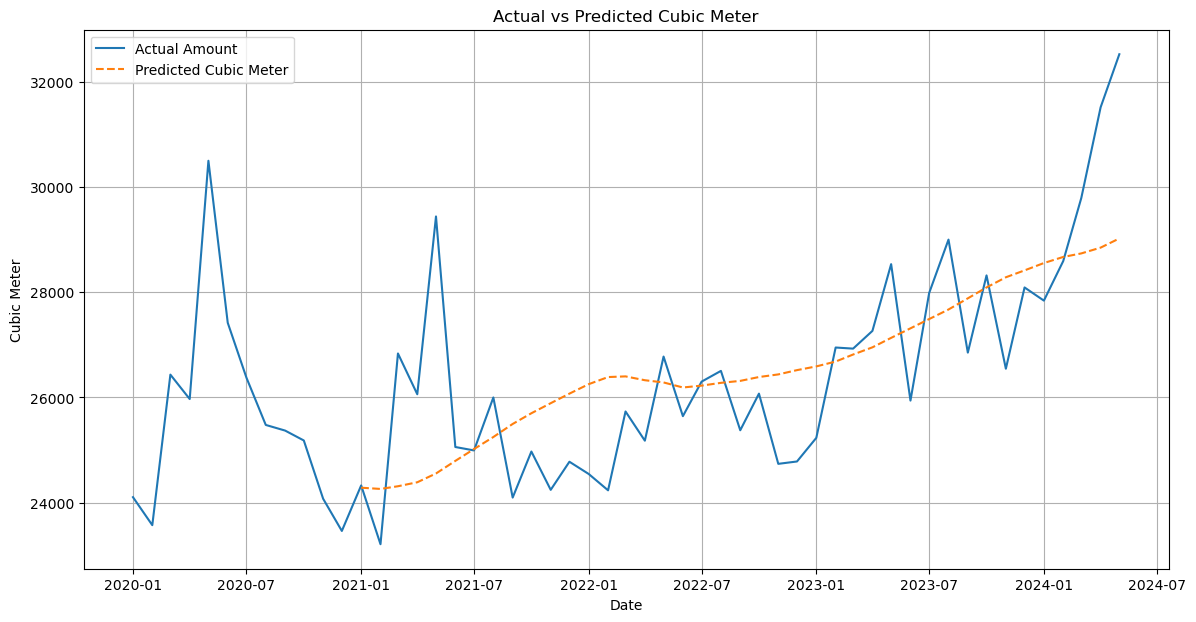

In [22]:
# Plot the actual and predicted amounts
plt.figure(figsize=(14, 7))
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Actual Amount')
plt.plot(monthly_sum.index, monthly_sum['Predicted_CU.M.'], label='Predicted Cubic Meter', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cubic Meter')
plt.title('Actual vs Predicted Cubic Meter')
plt.legend()
plt.grid(True)
plt.show()


# Evaluating the Accuracy of the Model

In [23]:
# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(monthly_sum['CU.M.'].iloc[sequence_length:], monthly_sum['Predicted_CU.M.'].iloc[sequence_length:])
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sum['CU.M.'].iloc[sequence_length:], monthly_sum['Predicted_CU.M.'].iloc[sequence_length:])

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 2231641.89
Root Mean Squared Error (RMSE): 1493.87
Mean Absolute Error (MAE): 1120.94


# Forecasting Cubic Meter up to Dec 2025

In [30]:
# Reset index and prepare your data
df_reset = df.reset_index()
monthly_sum = df_reset.groupby(df_reset['Date'].dt.to_period('M'))[['Amount', 'CU.M.']].sum().reset_index()
monthly_sum['Amount'] = monthly_sum['Amount'].round(2)
monthly_sum['CU.M.'] = monthly_sum['CU.M.'].round(2)
monthly_sum['Date'] = monthly_sum['Date'].dt.to_timestamp()
monthly_sum.set_index('Date', inplace=True)

# Forecast future values
last_date = monthly_sum.index.max()

# Ensure 'last_date' is a Timestamp object for date arithmetic
if isinstance(last_date, pd.Period):
    last_date = last_date.to_timestamp()

# Define the future date range
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), end='2025-12-31', freq='M')

# Create a DataFrame for future dates with a placeholder for 'CU.M.'
future_df = pd.DataFrame(index=future_dates, columns=['Amount'])

# Initialize the last known sequence
last_sequence = X_scaled[-sequence_length:]
forecasted_amounts = []

for _ in range(len(future_dates)):
    # Predict the next value
    next_prediction_scaled = model.predict(last_sequence.reshape(1, sequence_length, 1))
    next_prediction = scaler_y.inverse_transform(next_prediction_scaled)[0, 0]
    forecasted_amounts.append(next_prediction)
    
    # Update the sequence with the new prediction
    # Use the mean CU.M. as a placeholder; replace with actual forecasted CU.M. if available
    new_cu_m = monthly_sum['Amount'].mean()  
    new_cu_m_scaled = scaler_X.transform([[new_cu_m]])[0, 0]
    last_sequence = np.append(last_sequence[1:], [[new_cu_m_scaled]], axis=0)

# Add forecasted values to the future DataFrame
future_df['CU.M.'] = forecasted_amounts

# Set the index name for clarity
future_df.index.name = 'Date'

1/1 [==============================] - ETA: 0s

D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


D:\Anaconda2\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


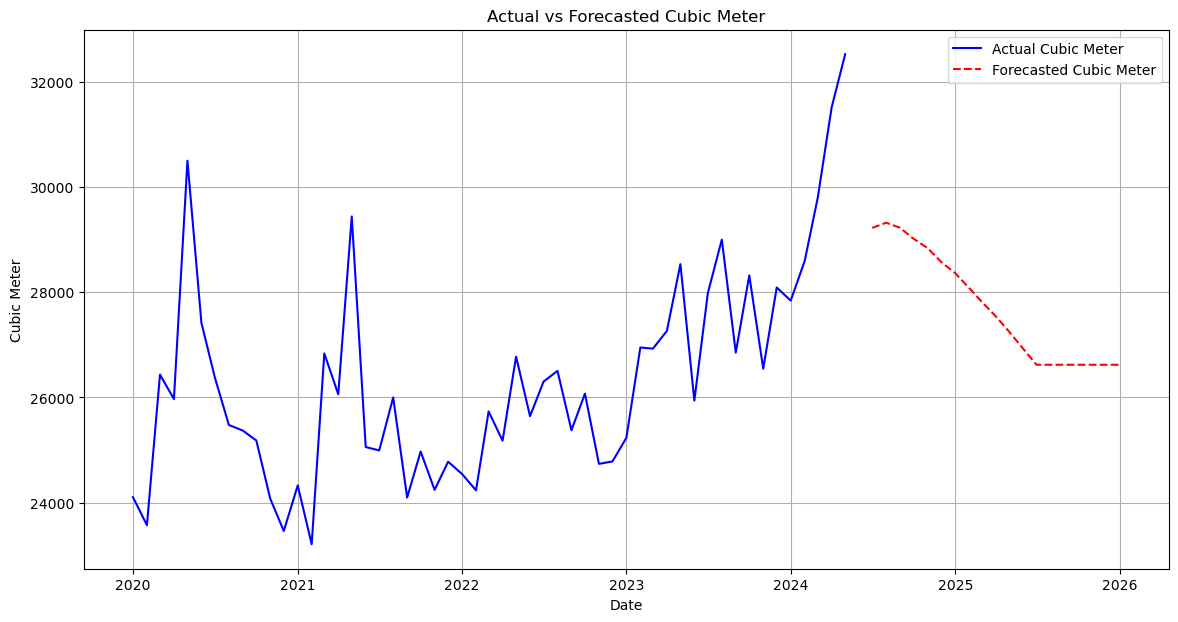

                   CU.M.
Date                    
2024-06-30  29221.484375
2024-07-31  29319.890625
2024-08-31  29223.132812
2024-09-30  29014.498047
2024-10-31  28838.705078
2024-11-30  28576.177734
2024-12-31  28364.275391
2025-01-31  28083.554688
2025-02-28  27821.169922
2025-03-31  27546.294922
2025-04-30  27252.199219
2025-05-31  26929.794922
2025-06-30  26621.603516
2025-07-31  26621.603516
2025-08-31  26621.603516
2025-09-30  26621.603516
2025-10-31  26621.603516
2025-11-30  26621.603516
2025-12-31  26621.603516


In [32]:
# Plot the actual and forecasted values
plt.figure(figsize=(14, 7))
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Actual Cubic Meter', color='blue')
plt.plot(future_df.index, future_df['CU.M.'], label='Forecasted Cubic Meter', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Cubic Meter')
plt.title('Actual vs Forecasted Cubic Meter')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values
print(future_df[['CU.M.']])